# Cardiovascular Desease Prediction Project.

This project is for education purposes. here I will exercise skills in machine learning, more precisely classification algorithms.

[data source: Kaggle](https://www.kaggle.com/sulianova/cardiovascular-disease-dataset/code)


**Data Description:**

There are 3 types of input features:

* Objective: factual information;
* Examination: results of medical examination;
* Subjective: information given by the patient.

Features:

* Age | Objective Feature | age | int (days)
* Height | Objective Feature | height | int (cm) |
* Weight | Objective Feature | weight | float (kg) |
* Gender | Objective Feature | gender | categorical code | 1 - women, 2 - men |
* Systolic blood pressure | Examination Feature | ap_hi | int |
* Diastolic blood pressure | Examination Feature | ap_lo | int |
* Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
* Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
* Smoking | Subjective Feature | smoke | binary | 0: no, 1: yes |
* Alcohol intake | Subjective Feature | alco | binary | 0: no, 1: yes |
* Physical activity | Subjective Feature | active | binary | 0: no, 1: yes |
* Presence or absence of cardiovascular disease | Target Variable | cardio | binary | 0: no, 1: yes |

All of the dataset values were collected at the moment of medical examination.


**Created Features:**

* BMI - Body mass index | 0: Underweight, 1: Normal, 2: Overweight, 3: Obesity 1, 4: Obesity 2, 5: Morbid obesity
* cat_blood_pressure | 0: Normal, 1: Elevated, 2: Hypertension 1, 3: Hypertension 2, 4: Hypertension 3.
* cat_weight | 0: underweight, 1: normal, 2: elevated, 3: overweight, 4: obesity, 5: morbid obesity.

# Imports

In [1]:
import random
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, recall_score
from sklearn.metrics import precision_score, f1_score, cohen_kappa_score,balanced_accuracy_score

warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'xgboost'

# Helper Functions

In [ ]:
SEED = 43

%matplotlib inline
%pylab inline

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['font.size'] = 18

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.expand_frame_repr', False)

sns.set()


# Function to categorize BMI feature
def cat_bmi(bmi):
    if bmi >= 17 and bmi < 18.5:
        return int(0) # 0: underweight
    elif bmi >= 18.5 and bmi < 25:
        return int(1) # 1: normal
    elif bmi >= 25 and bmi < 30:
        return int(2) # 2: elevated
    elif bmi >= 30 and bmi < 35:
        return int(3) # 3: overweight
    elif bmi >= 35 and bmi < 40:
        return int(4) # 4: obesity
    else:
        return int(5) # 5: morbid obesity

    
# Function to annotate bar vaues in the graphs.
def annot_plot(plot):
    for p in plot.patches:
        plot.annotate(format(int(p.get_height())), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points',
                       fontsize = 14)
    return None

# Load Data

In [ ]:
df1 = pd.read_csv('C:\\Users\\felip\\repos\\cardio\\Cardiovascular-disease-prediction\\data\\cardio_train.csv',
                 sep = ';', 
                 index_col = 'id')
df1.head()

## Data Description

In [ ]:
df1.dtypes

In [ ]:
# Cheking for NAN data.

df1.isnull().sum().sum()

In [ ]:
df1.describe().T

In [ ]:
df1.shape

# Data Cleaning

## Data Questions Based on Data Features Describe.

**Height:** The minimum height is 55cm and the maximum is 250 cm. Is that right? There are patients with nanism or gigantism in the dataset?

In [ ]:
# Checking if there are many height outliers and the impact of it on the entire dataset.

shorter = len(df1[df1["height"] < 130])
bigger = len(df1[df1["height"] > 210])

print(f'There are {shorter} patients with height under 130cm'
      f' and {bigger} patient bigger than 210cm.'
      f'\nIt corresponds to {round((bigger + shorter) * 100 / len(df1), 2)}% of the dataset.')

In [ ]:
# The patients under 130cm and bigger than 210cm will be excluded from dataset.

df2 = df1[df1["height"] >= 130]
df2 = df2[df2["height"] <= 210]

**Weight:** The minimum weight is 10kg and the maximum is 200kg. Is that right?patients with just 10kg?

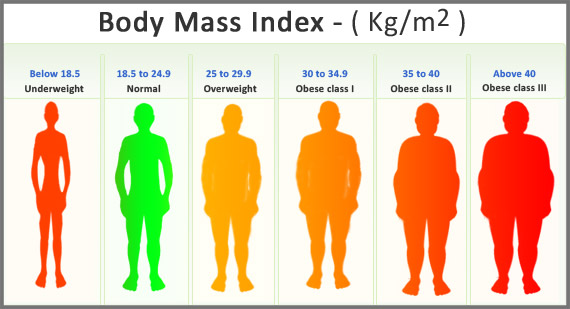

In [ ]:
# Checking for outliers in the weight feature.

thinner = len(df2[df2['weight'] < 40])
print(f'There are {thinner} patients with weight under 40kg.')

In [ ]:
# Excluding patients with less than 40kg.

df2 = df2[df2['weight'] > 40]

**Blood pressure:** There are blood pressures with negative values, is that possible?

- After some research I saw that it is possible to a blood pressure be negative, but in order to the low impact on the dataset, we decided to exclude them.



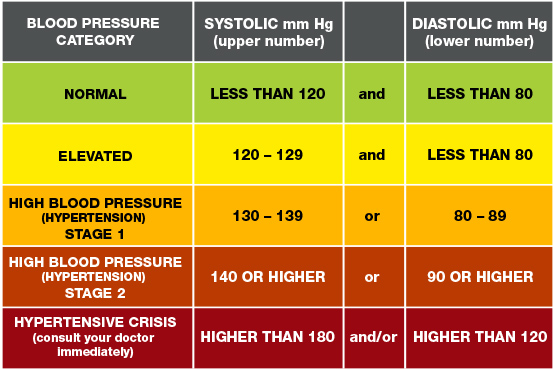



In [ ]:
# Looking for negative blood pressure values.

negative_ap_hi = len(df2[df2['ap_hi'] < 0])
negative_ap_lo = len(df2[df2['ap_lo'] < 0])

print(f'There are {negative_ap_hi} cases of negative ap_hi and {negative_ap_lo} cases of negative ap_lo')

In [ ]:
# The negative blood pressure cases and to low or to high will be excluded.

df2 = (df2[df2['ap_hi'] > 50])
df2 = (df2[df2['ap_hi'] < 220])
df2 = (df2[df2['ap_lo'] > 50])
df2 = (df2[df2['ap_lo'] < 180])

In [ ]:
# Transforming age from days to years
df2['age'] = df2['age'].apply(lambda x: int(x/365))

In [ ]:
print(f'After the data cleaning ware excluded from the original dataset {df1.shape[0] - df2.shape[0]} rows.')

In [ ]:
df2.shape

In [ ]:
df2.describe().T 

# Feature Enginnering

In [ ]:
df3 = df2.copy()

In [ ]:
# Creating BMI Feature
df3['bmi'] = (df3['weight']/((df3['height']/100)**2)).round(2)

# Categorizing BMI
df3['cat_weight'] = df3['bmi'].apply(cat_bmi)

# Categorizing Blood Pressure
df3['cat_blood_pressure'] = df3.apply(lambda x: 0 if x['ap_hi'] < 120 and x['ap_lo'] < 80 else
                                      1 if 120 <= x['ap_hi'] < 130 and x['ap_lo'] < 80 else
                                      2 if 130 <= x['ap_hi'] < 140 or 80 <= x['ap_lo'] < 90 else
                                      3 if 140 <= x['ap_hi'] <= 180 or 90 <= x['ap_lo'] <= 120
                                      else 4, axis  =1)

In [ ]:
df3.reset_index('id', inplace = True, drop = True)
df3.head()

In [ ]:
df3.describe().T

In [ ]:
# Due to lack of information about 'BMI', we decided to mantein higher BMI in the dataset.
df3.query('bmi > 60')

# EDA - Exploratory Data Analysis

In [ ]:
df3.head()

In [ ]:
df4 = df3.copy()

## Univariate Ananalysis

### Age

In [ ]:
df4['age'].hist(bins = 20)

In [ ]:
age_plot = sns.countplot(df4['age'])

annot_plot(age_plot)

plt.title('Age Distribution', fontsize = 18);

### Cardio Disease

In [ ]:
# Disease proportion on dataset

print(f'Patients without cardio disease: {df4.cardio.value_counts()[0]} - {round((df4.cardio.value_counts()[0] / len(df4)) * 100, 2)}%'
      f'\nPatients with cardio disease: {df4.cardio.value_counts()[1]} -  {round((df4.cardio.value_counts()[1] / len(df4)) * 100, 2)}%')

In [ ]:
disease_plot = sns.countplot(df4['cardio'])

annot_plot(disease_plot)

plt.xticks([0, 1], ['No', 'Yes'], fontsize = 14, rotation = 'horizontal')
plt.title('Cardio Disease', fontsize = 18);

In [ ]:
# Boxplot - Cardio Disease by Age.

ax = sns.boxplot('cardio', 'age', data = df4)
ax.set_title('Cardio Disease by Age', fontsize = 18)
plt.xticks([0, 1], ['No', 'Yes'], fontsize = 14)
ax;

In [ ]:
sns.countplot('smoke', hue = 'cardio', data = df4)

plt.xticks([0, 1], ['No', 'Yes'], fontsize = 14, rotation = 'horizontal')
plt.legend(labels = ['No', 'Yes'], fontsize = 14)
plt.title('Cardio Disese by Smoker', fontsize = 18)

In [ ]:
sns.countplot('cholesterol', hue = 'cardio', data = df4)

plt.xticks([0, 1, 2], ['normal', 'above normal', 'well above normal'], fontsize = 14, rotation = 'horizontal')
plt.legend(labels = ['No', 'Yes'], fontsize = 14)
plt.title('Cardio Disese by Cholesterol', fontsize = 18);

In [ ]:
sns.boxplot('cardio', 'bmi', data = df4)

In [ ]:
df4.head()

### Gender

In [ ]:
df4['gender'].value_counts()

In [ ]:
gender_plot = sns.countplot(df4['gender'])

annot_plot(gender_plot)

plt.title('Gender Distribution', fontsize = 18)
plt.xticks([0, 1], ['Women', 'Man'], rotation = 'horizontal', fontsize = 14);

In [ ]:
# BoxPlot - Blod Pressure by Age

sns.boxplot('cat_blood_pressure', 'age',data = df4)

plt.title('Blood Pressure Cagories by Age', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4], ['Normal', 'Elevated', 'Hypertension 1', 'Hypertension 2', 'Hypertension 3'], fontsize = 14);

In [ ]:
# Violin Plot - Cardio Disease by BMI

sns.boxplot('cardio', 'bmi',data = df4)

plt.title('Blood Pressure Cagories by Age', fontsize = 18)
plt.xticks([0, 1], ['No', 'Yes'], fontsize = 14);

### Bloob Pressure Cat.

In [ ]:
blod_p = sns.countplot(df4['cat_blood_pressure'])

annot_plot(blod_p)

plt.title('Blood Pressure Cagories', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4], ['Normal', 'Elevated', 'Hypertension 1', 'Hypertension 2', 'Hypertension 3'], fontsize = 14);

### BMI analysis
    

In [ ]:
#- Second Cycle.
# Looking for BMI outliers

sns.boxplot(df4['bmi'])

In [ ]:
df4.query('bmi > 60').count()

In [ ]:
df4.shape

In [ ]:
# After see that there are some BMI outliers, we decided to exclude BMI bigger than 60.

df4 = df4.query('bmi <= 60')
df4.shape

In [ ]:
print(f'Were excluded {68488 - 68469} rows from datatset')

In [ ]:
sns.boxplot(df4['bmi'])

## Bivariate Analysis

### Cholesterol and Cardio Diseases

In [ ]:
# - Second Cycle.
# Relation between cholesterol and cardio diseases

ax = sns.countplot(df4['cholesterol'], hue = df4['cardio'])
ax.set_title('Cardio Disease by Cholesterol Type', fontsize = 18)

annot_plot(ax)

plt.xticks([0, 1, 2], labels = ['Normal', 'Above Normal', 'Well Above Normal'], fontsize = 14)
plt.legend(labels = ['No cardio disease', 'Cardio disease'], fontsize = 14);

### Blood Pressure (Hypertension) and Cardio Disease

In [ ]:
# - Second Cycle.
# Relation between cholesterol and cardio diseases

ax = sns.countplot(df4['cat_blood_pressure'], hue = df4['cardio'])
ax.set_title('Cardio Disease by Blood Pressure (Hypertension)', fontsize = 18)

annot_plot(ax)

plt.xticks([0, 1, 2, 3, 4], labels = ['Normal', 'Elevated', 'Hypertension 1', 'Hypertension 2', 'Hypertension 3'], fontsize = 14)
plt.legend(labels = ['No cardio disease', 'Cardio disease'], fontsize = 14);

### BMI Category (cat_weight) and Cardio Diseases

In [ ]:
# - Second Cycle.
# Relation between BMI and cardio diseases

ax = sns.countplot(df4['cat_weight'], hue = df4['cardio'])
ax.set_title('Cardio Disease by BMI Category', fontsize = 18)

annot_plot(ax)

plt.xticks([0, 1, 2, 3, 4, 5],
           labels = ['underweight', 'normal', 'elevated', 'overweight', 'obesity', 'morbid obesity'], fontsize = 14)
plt.legend(labels = ['No cardio disease', 'Cardio disease'], fontsize = 14);

In [ ]:
# - Second Cycle.
# Relation between Smoke and cardio diseases

ax = sns.countplot(df4['smoke'], hue = df4['cardio'])
ax.set_title('Cardio Disease by Smokers', fontsize = 18)

annot_plot(ax)

plt.xticks([0, 1],
           labels = ['Not Smoker', 'Smoker'], fontsize = 14)
plt.legend(labels = ['No cardio disease', 'Cardio disease'], fontsize = 14);

## Multivariate Analysis

In [ ]:
df4.head()

In [ ]:
corr = df4.corr()

f, ax = plt.subplots(figsize = (15,15))
sns.heatmap(corr, annot=True, fmt=".3f", linewidths=0.5, ax=ax)
plt.title('Correlation Heatmap', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(rotation = 'horizontal', fontsize = 14);

In [ ]:
df4.hist(figsize = (20,12), bins = 25);

# Features Selection

In [ ]:
df5 = df4.copy()
df5 = df5[['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke',
           'alco', 'active', 'bmi', 'cat_weight', 'cat_blood_pressure', 'cardio']]

df5.head()

In [ ]:
# Second Cycle - excluded some features -> ['gender','ap_hi', 'ap_lo', 'bmi']

df5_2 = df5[['age', 'height', 'weight', 'cholesterol', 'gluc', 'smoke',
           'alco', 'active', 'cat_weight', 'cat_blood_pressure', 'cardio']]

df5_2.head()

In [ ]:
x = df5.drop('cardio', axis = 1)

y = df5['cardio']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = SEED,  stratify = y)

print(f'x_train: {x_train.shape[0]}\n'
      f'x_test: {x_test.shape[0]}\n\n'
      f'y_train: {y_train.shape[0]}\n'
      f'y_test: {y_test.shape[0]}')

### Second Cycle

In [ ]:
x_2 = df5_2.drop('cardio', axis = 1)

y_2 = df5_2['cardio']

x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_2, y_2, random_state = SEED,  stratify = y)

print(f'x_train: {x_train_2.shape[0]}\n'
      f'x_test: {x_test_2.shape[0]}\n\n'
      f'y_train: {y_train_2.shape[0]}\n'
      f'y_test: {y_test_2.shape[0]}')

### Third Cycle
    - Tried to rescale the dataset in order to improove metrics.

In [ ]:
x_3 = df5.drop('cardio', axis = 1)

y_3 = df5['cardio']

In [ ]:
# Rescaling Features - saving as pickle

mms = MinMaxScaler()
rbs = RobustScaler()

x_3['age'] = mms.fit_transform(x_3[['age']].values)
pickle.dump(mms, open('C:\\Users\\felip\\repos\\cardio\\Cardiovascular-disease-prediction\\Parameters\\age_scaler.pkl', 'wb'))

x_3['height'] = rbs.fit_transform(x_3[['height']].values)
pickle.dump(rbs, open('C:\\Users\\felip\\repos\\cardio\\Cardiovascular-disease-prediction\\Parameters\\height_scaler.pkl', 'wb'))

x_3['weight'] = rbs.fit_transform(x_3[['weight']].values)
pickle.dump(rbs, open('C:\\Users\\felip\\repos\\cardio\\Cardiovascular-disease-prediction\\Parameters\\weight_scaler.pkl', 'wb'))

x_3['ap_hi'] = rbs.fit_transform(x_3[['ap_hi']].values)
pickle.dump(rbs, open('C:\\Users\\felip\\repos\\cardio\\Cardiovascular-disease-prediction\\Parameters\\ap_hi_scaler.pkl', 'wb'))

x_3['ap_lo'] = rbs.fit_transform(x_3[['ap_lo']].values)
pickle.dump(mms, open('C:\\Users\\felip\\repos\\cardio\\Cardiovascular-disease-prediction\\Parameters\\ap_lo_scaler.pkl', 'wb'))                     
                      
x_3['cholesterol'] = rbs.fit_transform(x_3[['cholesterol']].values)
pickle.dump(mms, open('C:\\Users\\felip\\repos\\cardio\\Cardiovascular-disease-prediction\\Parameters\\cholesterol_scaler.pkl', 'wb')) 

x_3['bmi'] = rbs.fit_transform(x_3[['bmi']].values)
pickle.dump(mms, open('C:\\Users\\felip\\repos\\cardio\\Cardiovascular-disease-prediction\\Parameters\\bmi_scaler.pkl', 'wb')) 

x_3['cat_weight'] = rbs.fit_transform(x_3[['cat_weight']].values)
pickle.dump(mms, open('C:\\Users\\felip\\repos\\cardio\\Cardiovascular-disease-prediction\\Parameters\\cat_weight_scaler.pkl', 'wb')) 

x_3['cat_blood_pressure'] = rbs.fit_transform(x_3[['cat_blood_pressure']].values)
pickle.dump(mms, open('C:\\Users\\felip\\repos\\cardio\\Cardiovascular-disease-prediction\\Parameters\\cat_blood_pressure_scaler.pkl', 'wb'))

In [ ]:
x3_train, x3_test, y3_train, y3_test = train_test_split(x_3, y_3, test_size=0.3, random_state = SEED)

print(f'x_train: {x3_train.shape[0]}\n'
      f'x_test: {x3_test.shape[0]}\n\n'
      f'y_train: {y3_train.shape[0]}\n'
      f'y_test: {y3_test.shape[0]}')

# Machine Learning Modeling
**Classifier Models to implement:**

* **KNeighborsClassifier**

* **RandomForestClassifier**

* **XGBoostClassifier**

* **LGBMClassifier**

## KNeighborsClassifier 

In [ ]:
'''
KN_model = KNeighborsClassifier(weights = 'distance', n_jobs = -1)

KN_model.fit(x_train, y_train)
y_hat_KN = KN_model.predict(x_test)

# Evaluation Metrics
KN_cross_val__avg_acc = cross_val_score(KN_model, x_train, y_train, cv = 5).mean()
KN_precision = precision_score(y_test, y_hat_KN)
KN_recall = recall_score(y_test, y_hat_KN)
KN_f1_score = f1_score(y_test, y_hat_KN)
KN_Kappa_score = cohen_kappa_score(y_test, y_hat_KN)
KN_balanced_acc = balanced_accuracy_score(y_test, y_hat_KN)

KN_metrics = pd.DataFrame({'model':['KNN Classifier'],
                           'accuracy':[KN_cross_val__avg_acc],
                           'precision':[KN_precision],
                           'recall':[KN_recall],
                           'f1_score':[KN_f1_score],
                           'kappa_score': [KN_Kappa_score], 
                           'balanced accuracy':[KN_balanced_acc]})

KN_metrics
'''

In [ ]:
#print(classification_report(y_test, y_hat_KN))

## RandonForestClassifier

In [ ]:
'''
RF_model = RandomForestClassifier(n_estimators = 1500, n_jobs = -1, random_state = SEED)

RF_model.fit(x_train, y_train)
y_hat_RF = RF_model.predict(x_test)

# Evaluation Metrics
RF_cross_val__avg_acc = cross_val_score(RF_model, x_train, y_train, cv = 5).mean()
RF_precision = precision_score(y_test, y_hat_RF)
RF_recall = recall_score(y_test, y_hat_RF)
RF_f1_score = f1_score(y_test, y_hat_RF)
RF_Kappa_score = cohen_kappa_score(y_test, y_hat_RF)
RF_balanced_acc = balanced_accuracy_score(y_test, y_hat_RF)

RF_metrics = pd.DataFrame({'model':['Random Forest Classifier'],
                           'accuracy':[RF_cross_val__avg_acc],
                           'precision':[RF_precision],
                           'recall':[RF_recall],
                           'f1_score':[RF_f1_score],
                           'kappa_score':[RF_Kappa_score],
                           'balanced accuracy':[RF_balanced_acc]})

RF_metrics
'''

In [ ]:
#print(classification_report(y_test, y_hat_RF))

In [ ]:
# Cross Validation RandomForest

#cross_val_score(RF_model, x_train, y_train, cv = 5)

### Second Cycle Random Forest

In [ ]:
RF_model_2 = RandomForestClassifier(n_estimators = 1500, n_jobs = -1, random_state = SEED)

RF_model_2.fit(x_train_2, y_train_2)
y_hat_RF_2 = RF_model_2.predict(x_test_2)

# Evaluation Metrics
RF2_cross_val__avg_acc = cross_val_score(RF_model_2, x_train_2, y_train_2, cv = 5).mean()
RF2_precision = precision_score(y_test_2, y_hat_RF_2)
RF2_recall = recall_score(y_test_2, y_hat_RF_2)
RF2_f1_score = f1_score(y_test_2, y_hat_RF_2)
RF2_Kappa_score = cohen_kappa_score(y_test_2, y_hat_RF_2)
RF2_balanced_acc = balanced_accuracy_score(y_test_2, y_hat_RF_2)

RF_metrics_2 = pd.DataFrame({'model':['Random Forest Classifier_2'],
                            'accuracy':[RF2_cross_val__avg_acc],
                            'precision':[RF2_precision],
                            'recall':[RF2_recall],
                            'f1_score':[RF2_f1_score],
                            'kappa_score':[RF2_Kappa_score],
                            'balanced accuracy':[RF2_balanced_acc]})

RF_metrics_2

## XGBoost Classifier

In [ ]:
'''
XGB_model = xgb.XGBClassifier(n_jobs = -1)

XGB_model.fit(x_train, y_train)
y_hat_XGB = XGB_model.predict(x_test)

# Evaluation Metrics
XGB_cross_val__avg_acc = cross_val_score(XGB_model, x_train, y_train, cv = 5).mean()
XGB_precision = precision_score(y_test, y_hat_XGB)
XGB_recall = recall_score(y_test, y_hat_XGB)
XGB_f1_score = f1_score(y_test, y_hat_XGB)
XGB_Kappa_score = cohen_kappa_score(y_test, y_hat_XGB)
XGB_balanced_acc = balanced_accuracy_score(y_test, y_hat_XGB)


XGB_metrics = pd.DataFrame({'model':['XGB Classifier'],
                           'accuracy':[XGB_cross_val__avg_acc],
                           'precision':[XGB_precision],
                           'recall':[XGB_recall],
                           'f1_score':[XGB_f1_score],
                           'kappa_score': [XGB_Kappa_score],
                           'balanced accuracy':[XGB_balanced_acc]})

XGB_metrics
'''

In [ ]:
#print(classification_report(y_test, y_hat_XGB))

In [ ]:
# Cross Validation XGBoost Classifier

#cross_val_score(XGB_model, x_train, y_train, cv = 5)

### Second Cycle XGBoost

In [ ]:
XGB_model_2 = xgb.XGBClassifier(n_jobs = -1)

XGB_model_2.fit(x_train_2, y_train_2)
y_hat_XGB_2 = XGB_model_2.predict(x_test_2)

# Evaluation Metrics
XGB2_cross_val__avg_acc = cross_val_score(XGB_model_2, x_train_2, y_train_2, cv = 5).mean()
XGB2_precision = precision_score(y_test_2, y_hat_XGB_2)
XGB2_recall = recall_score(y_test_2, y_hat_XGB_2)
XGB2_f1_score = f1_score(y_test_2, y_hat_XGB_2)
XGB2_Kappa_score = cohen_kappa_score(y_test_2, y_hat_XGB_2)
XGB2_balanced_acc = balanced_accuracy_score(y_test_2, y_hat_XGB_2)


XGB_metrics_2 = pd.DataFrame({'model':['XGB2 Classifier'],
                           'accuracy':[XGB2_cross_val__avg_acc],
                           'precision':[XGB2_precision],
                           'recall':[XGB2_recall],
                           'f1_score':[XGB2_f1_score],
                           'kappa_score': [XGB2_Kappa_score],
                           'balanced accuracy':[XGB2_balanced_acc]})

XGB_metrics_2

## LGBMClassifier

In [ ]:
'''
LGBM_model = LGBMClassifier(random_state = SEED, n_jobs = -1)

LGBM_model.fit(x_train, y_train)
y_hat_LGBM = LGBM_model.predict(x_test)

LGBM_cross_val__avg_acc = cross_val_score(LGBM_model, x_train, y_train, cv = 5).mean()
LGBM_precision = precision_score(y_test, y_hat_LGBM)
LGBM_recall = recall_score(y_test, y_hat_LGBM)
LGBM_f1_score = f1_score(y_test, y_hat_LGBM)
LGBM_Kappa_score = cohen_kappa_score(y_test, y_hat_LGBM)
LGBM_balanced_acc = balanced_accuracy_score(y_test, y_hat_LGBM)

LGBM_metrics = pd.DataFrame({'model':['LGBM Classifier'],
                           'accuracy':[LGBM_cross_val__avg_acc],
                           'precision':[LGBM_precision],
                           'recall':[LGBM_recall],
                           'f1_score':[LGBM_f1_score],
                           'kappa_score':[LGBM_Kappa_score],
                           'balanced accuracy':[LGBM_balanced_acc]})

LGBM_metrics
'''

In [ ]:
#print(classification_report(y_test, y_hat_LGBM))

### Second Cycle LGBM

In [ ]:
LGBM_model_2 = LGBMClassifier(random_state = SEED, n_jobs = -1)

LGBM_model_2.fit(x_train_2, y_train_2)
y_hat_LGBM_2 = LGBM_model_2.predict(x_test_2)

LGBM2_cross_val__avg_acc = cross_val_score(LGBM_model_2, x_train_2, y_train_2, cv = 5).mean()
LGBM2_precision = precision_score(y_test_2, y_hat_LGBM_2)
LGBM2_recall = recall_score(y_test_2, y_hat_LGBM_2)
LGBM2_f1_score = f1_score(y_test_2, y_hat_LGBM_2)
LGBM2_Kappa_score = cohen_kappa_score(y_test_2, y_hat_LGBM_2)
LGBM2_balanced_acc = balanced_accuracy_score(y_test_2, y_hat_LGBM_2)

LGBM_metrics_2 = pd.DataFrame({'model':['LGBM Classifier_2'],
                           'accuracy':[LGBM2_cross_val__avg_acc],
                           'precision':[LGBM2_precision],
                           'recall':[LGBM2_recall],
                           'f1_score':[LGBM2_f1_score],
                           'kappa_score':[LGBM2_Kappa_score],
                           'balanced accuracy':[LGBM2_balanced_acc]})

LGBM_metrics_2

## Best Model

In [ ]:
'''
best_model = pd.concat([KN_metrics, RF_metrics, XGB_metrics, LGBM_metrics], axis = 0)
best_model.to_dict(orient = 'list')
'''

In [ ]:
best_model = {'model': ['KNN Classifier', 'Random Forest Classifier', 'XGB Classifier',  'LGBM Classifier'],
              'accuracy': [0.6837014294649963, 0.710333829609155, 0.7292178803841046, 0.7346494827855189],
              'precision': [0.687083230427266, 0.7082386703336123, 0.7424376661182129, 0.7484748347737672],
              'recall': [0.6562868601085161, 0.6986317527718802, 0.6919084689785326, 0.694621372965322],
              'f1_score': [0.6713320463320464, 0.7034024107832076, 0.7162830453629648, 0.720543252171785],
              'kappa_score': [0.36329189535803186, 0.416409265094589, 0.45678356204913095, 0.46599838690652906],
              'balanced accuracy': [0.6815677706373214, 0.7081775145164353, 0.7282425269464621, 0.7328382200319438]}

best_model = pd.DataFrame(best_model)
best_model.sort_values(by = 'accuracy', ascending = False, inplace = True)
best_model.reset_index(inplace = True, drop = True)

best_model.style.highlight_max(color = 'darkorange')

## Hyperparameter Fine Tunning - Random Search - XGBoost

In [ ]:
params = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7], 
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
        }

MAX_EVAL = 10

In [ ]:
'''
results_list = []

for p in range(MAX_EVAL):
    # Choose values for parameters randomly
    hp = {k: random.sample(v, 1)[0]for k, v in params.items()}
    print(p, hp)
    
    # model
    xgb_model = xgb.XGBClassifier(n_estimator = hp['n_estimators'],
                                  max_depth = hp['max_depth'],
                                  subsample = hp['subsample'],
                                  colsample_bytree = hp['colsample_bytree'],
                                  min_child_weight = hp['min_child_weight'])
    
    # Performance
    result = cross_val_score(xgb_model, x_train, y_train, cv = 5).mean()
    results_list.append(result)
    
results_list
'''

In [ ]:
#pd.DataFrame(results_list)

In [ ]:
best_xbg = {'n_estimators': 1500,
            'max_depth': 3,
            'subsample': 0.1,
            'colsample_bytree': 0.3,
            'min_child_weight': 15,
            'n_jobs': -1}

In [ ]:
XGB_model = xgb.XGBClassifier(n_estimators = 1500,
                              max_depth = 3,
                              subsample = 0.1,
                              colsample_bytree = 0.3,
                              min_child_weight = 15,
                              n_jobs = -1)

XGB_model.fit(x_train, y_train)
y_hat_XGB = XGB_model.predict(x_test)

# Evaluation Metrics
XGB_cross_val__avg_acc = cross_val_score(XGB_model, x_train, y_train, cv = 5).mean()
XGB_precision = precision_score(y_test, y_hat_XGB)
XGB_recall = recall_score(y_test, y_hat_XGB)
XGB_f1_score = f1_score(y_test, y_hat_XGB)
XGB_Kappa_score = cohen_kappa_score(y_test, y_hat_XGB)
XGB_balanced_acc = balanced_accuracy_score(y_test, y_hat_XGB)


XGB_metrics = pd.DataFrame({'model':['XGB Classifier'],
                           'accuracy':[XGB_cross_val__avg_acc],
                           'precision':[XGB_precision],
                           'recall':[XGB_recall],
                           'f1_score':[XGB_f1_score],
                           'kappa_score': [XGB_Kappa_score],
                           'balanced accuracy':[XGB_balanced_acc]})

XGB_metrics

## Hyperparameter Fine Tunning - Random Search - LGBM

    - Using RandomizedSearchCV.

In [ ]:
params_lgbm = {'max_depth': np.arange(2, 12, 2), 
               'num_leaves': 2 ** np.arange(2, 10, 2),
               'min_data_in_leaf': np.arange(100, 1050, 50), 
               'learning_rate': np.linspace(0.001, 0.6, 15),
               'colsample_bytree': np.linspace(0.1, 1, 5),
               'subsample': np.linspace(0.25, 1, 15),
               'n_estimators': np.arange(10, 105, 15)}

In [ ]:
LGBM_model = LGBMClassifier()

lgbm_classifier = RandomizedSearchCV(estimator = LGBM_model, param_distributions = params_lgbm,
                                scoring='f1', n_iter=100, cv=5, verbose=2,
                                random_state=SEED, n_jobs=-1)

lgbm_classifier.fit(x_train, y_train)
lgbm_classifier.best_estimator_

In [ ]:
LGBM_model = LGBMClassifier(colsample_bytree=0.55,
                            learning_rate=0.4716428571428571,
                            max_depth=10,
                            min_data_in_leaf=650,
                            n_estimators=25,
                            num_leaves=4,
                            random_state=43,
                            subsample=0.4107142857142857)

LGBM_model.fit(x_train, y_train)
y_hat_LGBM = LGBM_model.predict(x_test)

LGBM_cross_val__avg_acc = cross_val_score(LGBM_model, x_train, y_train, cv = 5).mean()
LGBM_precision = precision_score(y_test, y_hat_LGBM)
LGBM_recall = recall_score(y_test, y_hat_LGBM)
LGBM_f1_score = f1_score(y_test, y_hat_LGBM)
LGBM_Kappa_score = cohen_kappa_score(y_test, y_hat_LGBM)
LGBM_balanced_acc = balanced_accuracy_score(y_test, y_hat_LGBM)

LGBM_metrics = pd.DataFrame({'model':['LGBM Classifier'],
                           'accuracy':[LGBM_cross_val__avg_acc],
                           'precision':[LGBM_precision],
                           'recall':[LGBM_recall],
                           'f1_score':[LGBM_f1_score],
                           'kappa_score':[LGBM_Kappa_score],
                           'balanced accuracy':[LGBM_balanced_acc]})

LGBM_metrics

### Second Cycle - LGBM

In [ ]:
LGBM_model_2 = LGBMClassifier()

lgbm_classifier_2 = RandomizedSearchCV(estimator = LGBM_model_2, param_distributions = params_lgbm,
                                scoring='f1', n_iter=100, cv=5, verbose=2,
                                random_state=SEED, n_jobs=-1)

lgbm_classifier_2.fit(x_train_2, y_train_2)
lgbm_classifier_2.best_estimator_

In [ ]:
# Second Cycle

LGBM_model_2 = LGBMClassifier(colsample_bytree=0.325,
                              learning_rate=0.4716428571428571,
                              max_depth=6, min_data_in_leaf=850,
                              n_estimators=25,
                              num_leaves=16,
                              subsample=0.35714285714285715)

LGBM_model_2.fit(x_train_2, y_train_2)
y_hat_LGBM_2 = LGBM_model_2.predict(x_test_2)

LGBM2_cross_val__avg_acc = cross_val_score(LGBM_model_2, x_train_2, y_train_2, cv = 5).mean()
LGBM2_precision = precision_score(y_test_2, y_hat_LGBM_2)
LGBM2_recall = recall_score(y_test_2, y_hat_LGBM_2)
LGBM2_f1_score = f1_score(y_test_2, y_hat_LGBM_2)
LGBM2_Kappa_score = cohen_kappa_score(y_test_2, y_hat_LGBM_2)
LGBM2_balanced_acc = balanced_accuracy_score(y_test_2, y_hat_LGBM_2)

LGBM_metrics_2 = pd.DataFrame({'model':['LGBM Classifier_2'],
                           'accuracy':[LGBM2_cross_val__avg_acc],
                           'precision':[LGBM2_precision],
                           'recall':[LGBM2_recall],
                           'f1_score':[LGBM2_f1_score],
                           'kappa_score':[LGBM2_Kappa_score],
                           'balanced accuracy':[LGBM2_balanced_acc]})

LGBM_metrics_2

### Third Cycle - LGBM

In [ ]:
LGBM_model_3 = LGBMClassifier()

lgbm_classifier_3 = RandomizedSearchCV(estimator = LGBM_model_3, param_distributions = params_lgbm,
                                scoring='f1', n_iter=100, cv=5, verbose=2,
                                random_state=SEED, n_jobs=-1)

lgbm_classifier_3.fit(x3_train, y3_train)
lgbm_classifier_3.best_estimator_

In [ ]:
# Third Cycle

LGBM_model_3 = LGBMClassifier(colsample_bytree=0.325,
                              learning_rate=0.4716428571428571,
                              max_depth=10, min_data_in_leaf=650,
                              n_estimators=25,
                              num_leaves=4,
                              subsample=0.4107142857142857)

LGBM_model_3.fit(x3_train, y3_train)
y_hat_LGBM_3 = LGBM_model_3.predict(x3_test)

LGBM3_cross_val__avg_acc = cross_val_score(LGBM_model_3, x3_train, y3_train, cv = 5).mean()
LGBM3_precision = precision_score(y3_test, y_hat_LGBM_3)
LGBM3_recall = recall_score(y3_test, y_hat_LGBM_3)
LGBM3_f1_score = f1_score(y3_test, y_hat_LGBM_3)
LGBM3_Kappa_score = cohen_kappa_score(y3_test, y_hat_LGBM_3)
LGBM3_balanced_acc = balanced_accuracy_score(y3_test, y_hat_LGBM_3)

LGBM_metrics_3 = pd.DataFrame({'model':['LGBM Classifier_3'],
                           'accuracy':[LGBM3_cross_val__avg_acc],
                           'precision':[LGBM3_precision],
                           'recall':[LGBM3_recall],
                           'f1_score':[LGBM3_f1_score],
                           'kappa_score':[LGBM3_Kappa_score],
                           'balanced accuracy':[LGBM3_balanced_acc]})

LGBM_metrics_3

### Final Results

In [ ]:
LGBM_final_result = pd.concat([LGBM_metrics, LGBM_metrics_2, LGBM_metrics_3])
LGBM_final_result.reset_index(drop = True).style.highlight_max(color = 'darkorange')

**The third cycle, done with feture rescaling, perfomed a little better, so we will use it as final model.**

### Saving Final Model

In [ ]:
pickle.dump(LGBM_model_3, open('C:\\Users\\felip\\repos\\cardio\\Cardiovascular-disease-prediction\\Model\\LGBM_cardio_disease_predictor.pkl', 'wb'))

# Test Predictions

In [ ]:
import pandas as pd

def prediction_simulation():
    print('Please, imput patient informations: ')
    
    # Patient Infos
    age                = int(input('Age (years): '))
    gender             = int(input('Gender (1: Women, 2: Men): '))
    height             = int(input('Height (centimeters): '))
    weight             = int(input('Weight (kg): '))
    ap_hi              = int(input('Blood pressure - HI: '))
    ap_lo              = int(input('Blood pressure - LO: '))
    cholesterol        = int(input('Cholesterol (1: normal, 2: above normal, 3: well above normal): '))
    gluc               = int(input('Glucose (1: normal, 2: above normal, 3: well above normal): '))
    smoke              = int(input('Smoker (0: No, 1: Yes): '))
    alco               = int(input('Alcoolic (0: No, 1: Yes): '))
    active             = int(input('Physical activity (0: No, 1: Yes): '))
    
    # Creating BMI Feature
    bmi = (weight/(height/100)**2)

    # Categorizing BMI
    cat_weight = cat_bmi(bmi)

    # Categorizing Blood Pressure
    cat_blood_pressure =   float(0 if ap_hi < 120 and ap_lo < 80 else
                           1 if 120 <= ap_hi < 130 and ap_lo < 80 else
                           2 if 130 <= ap_hi < 140 or 80 <= ap_lo < 90 else
                           3 if 140 <= ap_hi <= 180 or 90 <= ap_lo <= 120
                           else 4)
    
    '''
    # rescale features
    age = mms.fit_transform(age)

    height = rbs.fit_transform(height)

    weight = rbs.fit_transform(weight)

    ap_hi = rbs.fit_transform(ap_hi)

    ap_lo = rbs.fit_transform(ap_lo)

    cholesterol = rbs.fit_transform(cholesterol)


    bmi = rbs.fit_transform(bmi)

    cat_weight = rbs.fit_transform(cat_weight)

    cat_blood_pressure = rbs.fit_transform(cat_blood_pressure)
    '''
    
    columns = ['age', 'gender', 'height', 'weight', 'hight_pressure', 'low_pressure',
               'cholesterol', 'glucose', 'smoker', 'alcohol', 'active', 'bmi', 'cat_weight', 'cat_blood_pressure']
    
    patient_infos = [[age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc,
                      smoke, alco, active, bmi, cat_weight, cat_blood_pressure]]
    df_test = pd.DataFrame(patient_infos, columns=columns)
    
    #return json.dumps(df_test.to_dict(orient='records'))
    return df_test

In [ ]:
LGBM_model.predict(prediction_simulation())

# Work Diary

* 10/03/21 - Started Cardiovascular_disease_prediction project
    - Done some data description analysis.
    - Started Feature Enginnering.
    
    
* 11/03/21 - Done some more fearture enginnering.
    - Finished first sicle of feature enginnering.
    - started EDA
    
    
* 13/03/21 - EDA.
    - Done some graph analysis.
    
    
* 15/03/21 - ML models
    - Testing some Classifier ML algorithms.
    - Evaluate ML algorithms performance.
    
    
* 16/03/21
    - Done finetunning for XGBoost and LGBM Classifiers.
    - Test RandomizedSearchCV for LGBM.
    
    - Best Results:
    
|model          |accuracy|precision|recall  |f1_score|kappa_score|balanced accuracy|
|---------------|:------:|:-------:|:------:|:------:|:---------:|:---------------:|
|LGBM Classifier|0.735097|0.750288 |0.692498|0.720236|0.466791   |0.733223         |


**Second Cycle.**



* 17/03/2021 - Second Cycle.
    - Done some more univariated and bivariated analysis.
    - Tried to exclude some redundant features in order to see how the models perform.
        - The models performed worst.
        

|cycle|model          |accuracy|precision|recall  |f1_score|kappa_score|balanced accuracy|
|-----|---------------|:------:|:-------:|:------:|:------:|:---------:|:---------------:|
|1    |LGBM Classifier|0.735097|0.750288 |0.692498|0.720236|0.466791   |0.733223         |        
|2    |LGBM Classifier_2	|0.702051	|0.702559	|0.670481	|0.686145	|0.392246	|0.696037|


**Third Cycle**

* 19/03/2021 - Third Cycle
    - Done feature rescaling in order to improove model metrics
        - The model with rescaled features performed a little better, so we will use it.
        
        
|cycle|model          |accuracy|precision|recall  |f1_score|kappa_score|balanced accuracy|
|-----|---------------|:------:|:-------:|:------:|:------:|:---------:|:---------------:|
|1    |LGBM Classifier|0.735097|0.750288 |0.692498|0.720236|0.466791   |0.733223         |        
|2    |LGBM Classifier_2|0.702051	|0.702559	|0.670481	|0.686145	|0.392246	|0.696037|
|3    |LGBM Classifier_3|0.731222	|0.752233	|0.688571	|0.718996	|0.467492	|0.733517|


* 20/03/2021 - Finished Project
    - Project finished